In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from tqdm import tqdm
import math
import json
import time
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("ag_news")

train_data = dataset["train"]
test_data = dataset["test"]

print(train_data[0])

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [3]:
def tokenize(text):
    return text.lower().split()

counter = Counter()

for sample in train_data:
    tokens = tokenize(sample["text"])
    counter.update(tokens)

vocab_size = 20000
most_common = counter.most_common(vocab_size - 2)

itos = ["<pad>", "<unk>"] + [word for word, _ in most_common]
stoi = {word: i for i, word in enumerate(itos)}

def encode(text):
    tokens = tokenize(text)
    return [stoi.get(t, stoi["<unk>"]) for t in tokens]

In [4]:
MAX_LEN = 128

class AGNewsDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]

        encoded = encode(text)[:MAX_LEN]
        encoded = torch.tensor(encoded, dtype=torch.long)

        return encoded, torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts, torch.stack(labels)

train_loader = DataLoader(
    AGNewsDataset(train_data),
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    AGNewsDataset(test_data),
    batch_size=64,
    collate_fn=collate_fn
)

In [5]:
class BDHClassifier(nn.Module):
    def __init__(self, vocab_size, n_layer=4, n_embd=128, n_head=4):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, n_embd)
        self.ln = nn.LayerNorm(n_embd)
        
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        
        N = 64  # internal dimension
        
        self.encoder = nn.Parameter(torch.randn(n_head, n_embd, N) * 0.02)
        self.encoder_v = nn.Parameter(torch.randn(n_head, n_embd, N) * 0.02)
        self.decoder = nn.Parameter(torch.randn(n_head * N, n_embd) * 0.02)
        
        self.classifier = nn.Linear(n_embd, 4)

    def forward(self, x):
        B, T = x.shape
        
        x = self.embed(x).unsqueeze(1)
        x = self.ln(x)
        
        for _ in range(self.n_layer):
            x_latent = x @ self.encoder
            x_sparse = F.relu(x_latent)
            
            scores = torch.matmul(x_sparse, x_sparse.transpose(-1, -2))
            scores = torch.tril(scores)
            y = torch.matmul(scores, x)
            
            y_latent = y @ self.encoder_v
            y_sparse = F.relu(y_latent)
            
            xy = x_sparse * y_sparse
            xy = xy.transpose(1,2).reshape(B,1,T,-1) @ self.decoder
            
            x = self.ln(x + xy)
        
        # Take last token representation
        x = x.squeeze(1)
        last_token = x[:, -1, :]
        
        return self.classifier(last_token)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
model = BDHClassifier(len(itos)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

history = {
    "train_loss": [],
    "val_accuracy": [],
    "epoch_time": []
}

def evaluate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

num_epochs = 5

In [8]:
for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    val_acc = evaluate()
    
    epoch_time = time.time() - start_time
    
    history["train_loss"].append(avg_train_loss)
    history["val_accuracy"].append(val_acc)
    history["epoch_time"].append(epoch_time)
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f}")
    print(f"Time: {epoch_time:.2f} sec")
    print("-"*40)

Epoch 1
Train Loss: 0.6322
Val Acc: 0.8604
Time: 43.78 sec
----------------------------------------
Epoch 2
Train Loss: 0.3288
Val Acc: 0.8854
Time: 42.80 sec
----------------------------------------
Epoch 3
Train Loss: 0.2680
Val Acc: 0.8946
Time: 43.30 sec
----------------------------------------
Epoch 4
Train Loss: 0.2286
Val Acc: 0.9000
Time: 43.05 sec
----------------------------------------
Epoch 5
Train Loss: 0.1976
Val Acc: 0.9007
Time: 42.99 sec
----------------------------------------


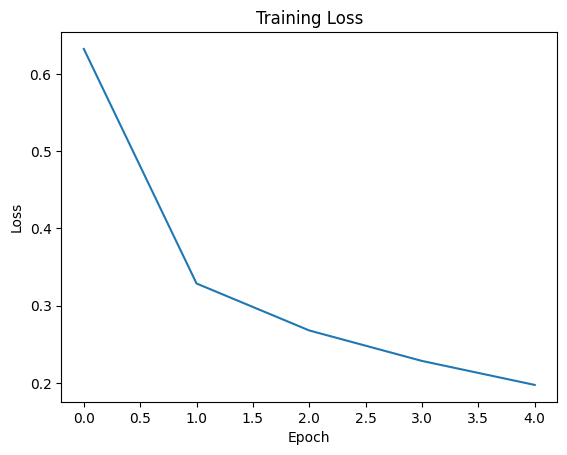

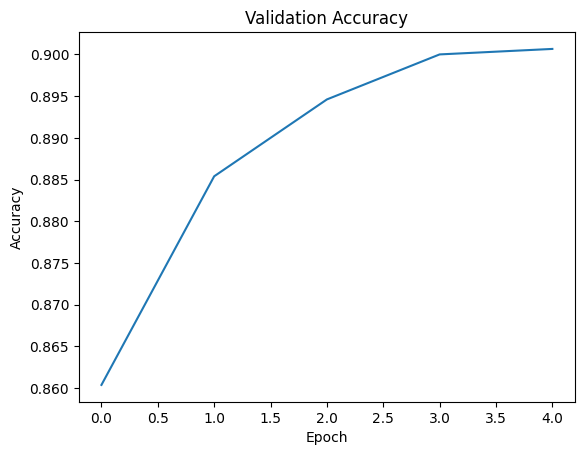

In [9]:
plt.figure()
plt.plot(history["train_loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(history["val_accuracy"])
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [10]:
with open("bdh_results.json", "w") as f:
    json.dump(history, f)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total Parameters:", count_parameters(model))
print("Model Size (MB):", count_parameters(model) * 4 / 1e6)

Total Parameters: 2659076
Model Size (MB): 10.636304


In [12]:
if torch.cuda.is_available():
    print("Peak GPU memory:",
          torch.cuda.max_memory_allocated() / 1e6, "MB")

Peak GPU memory: 536.375808 MB


In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=112, hidden_dim=160, num_layers=2):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1
        )
        self.classifier = nn.Linear(hidden_dim, 4)

    def forward(self, x):
        x = self.embed(x)
        _, (h_n, _) = self.lstm(x)
        last_hidden = h_n[-1]
        return self.classifier(last_hidden)


In [14]:
lstm_model = LSTMClassifier(len(itos)).to(device)
print("LSTM Params:", count_parameters(lstm_model))

LSTM Params: 2622084


In [8]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=112, num_heads=4, num_layers=3):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, MAX_LEN, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.classifier = nn.Linear(embed_dim, 4)

    def forward(self, x):
        B, T = x.shape
        x = self.embed(x) + self.pos_embed[:, :T, :]
        x = self.transformer(x)
        last_token = x[:, -1, :]
        return self.classifier(last_token)

In [16]:
transformer_model = TransformerClassifier(len(itos)).to(device)
print("Transformer Params:", count_parameters(transformer_model))


Transformer Params: 2710740


In [14]:
def train_model(model, model_name):
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        "train_loss": [],
        "val_accuracy": [],
        "epoch_time": []
    }
    
    print(f"\nTraining {model_name}")
    print("Parameters:", count_parameters(model))
    
    torch.cuda.reset_peak_memory_stats()
    
    for epoch in range(5):
        start_time = time.time()
        model.train()
        total_loss = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate_model(model)
        epoch_time = time.time() - start_time
        
        history["train_loss"].append(avg_loss)
        history["val_accuracy"].append(val_acc)
        history["epoch_time"].append(epoch_time)
        
        print(f"Epoch {epoch+1}")
        print(f"Loss: {avg_loss:.4f}")
        print(f"Val Acc: {val_acc:.4f}")
        print(f"Time: {epoch_time:.2f} sec")
        print("-"*40)
    
    if torch.cuda.is_available():
        print("Peak GPU memory:",
              torch.cuda.max_memory_allocated() / 1e6, "MB")
    
    return history


In [20]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


In [19]:
bdh_history = history  # from earlier

lstm_model = LSTMClassifier(len(itos)).to(device)
lstm_history = train_model(lstm_model, "LSTM")


Training LSTM
Parameters: 2622084
Epoch 1
Loss: 1.3134
Val Acc: 0.6425
Time: 49.89 sec
----------------------------------------
Epoch 2
Loss: 0.5932
Val Acc: 0.8342
Time: 49.48 sec
----------------------------------------
Epoch 3
Loss: 0.3865
Val Acc: 0.8649
Time: 49.68 sec
----------------------------------------
Epoch 4
Loss: 0.3147
Val Acc: 0.8825
Time: 49.37 sec
----------------------------------------
Epoch 5
Loss: 0.2683
Val Acc: 0.8876
Time: 49.44 sec
----------------------------------------
Peak GPU memory: 313.924608 MB


In [20]:
transformer_model = TransformerClassifier(len(itos)).to(device)
transformer_history = train_model(transformer_model, "Transformer")


Training Transformer
Parameters: 2710740
Epoch 1
Loss: 0.5461
Val Acc: 0.8596
Time: 40.31 sec
----------------------------------------
Epoch 2
Loss: 0.3358
Val Acc: 0.8879
Time: 40.25 sec
----------------------------------------
Epoch 3
Loss: 0.2783
Val Acc: 0.8955
Time: 40.18 sec
----------------------------------------
Epoch 4
Loss: 0.2407
Val Acc: 0.9009
Time: 40.06 sec
----------------------------------------
Epoch 5
Loss: 0.2120
Val Acc: 0.9059
Time: 40.22 sec
----------------------------------------
Peak GPU memory: 341.75232 MB


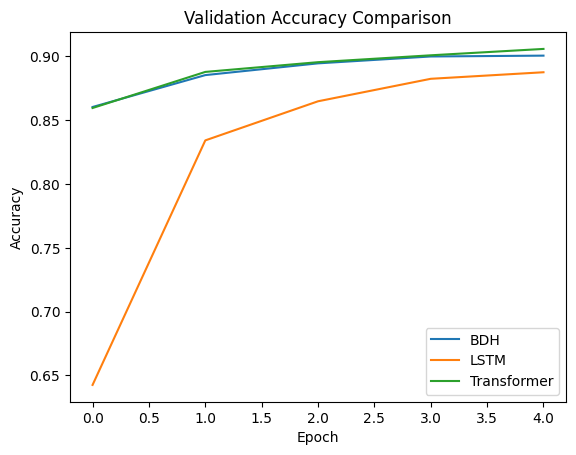

In [21]:
plt.figure()
plt.plot(bdh_history["val_accuracy"], label="BDH")
plt.plot(lstm_history["val_accuracy"], label="LSTM")
plt.plot(transformer_history["val_accuracy"], label="Transformer")
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


# training with data fractions

In [15]:
from torch.utils.data import Subset
import numpy as np

def get_fraction_loader(dataset_split, fraction, batch_size=64, shuffle=True):
    """
    dataset_split: HF dataset split (train_data)
    fraction: float (0.1, 0.25, 0.5, 1.0)
    """
    total_size = len(dataset_split)
    subset_size = int(total_size * fraction)
    
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]
    
    subset = Subset(AGNewsDataset(dataset_split), subset_indices)
    
    loader = DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )
    
    return loader


In [16]:
def train_model(model, model_name, train_loader):
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        "train_loss": [],
        "val_accuracy": [],
        "epoch_time": []
    }
    
    print(f"\nTraining {model_name}")
    print("Parameters:", count_parameters(model))
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    for epoch in range(5):
        start_time = time.time()
        model.train()
        total_loss = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate_model(model)
        epoch_time = time.time() - start_time
        
        history["train_loss"].append(avg_loss)
        history["val_accuracy"].append(val_acc)
        history["epoch_time"].append(epoch_time)
        
        print(f"Epoch {epoch+1}")
        print(f"Loss: {avg_loss:.4f}")
        print(f"Val Acc: {val_acc:.4f}")
        print(f"Time: {epoch_time:.2f} sec")
        print("-"*40)
    
    if torch.cuda.is_available():
        print("Peak GPU memory:",
              torch.cuda.max_memory_allocated() / 1e6, "MB")
    
    return history


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
fractions = [0.1, 0.25, 0.5, 1.0]

results = {
    "BDH": {},
    "LSTM": {},
    "Transformer": {}
}

for frac in fractions:
    print(f"\n\n==============================")
    print(f"Training with {int(frac*100)}% of data")
    print("==============================")
    
    train_loader_frac = get_fraction_loader(train_data, frac)
    
    # BDH
    bdh_model = BDHClassifier(len(itos), n_layer=4, n_embd=112, n_head=4).to(device)
    results["BDH"][frac] = train_model(bdh_model, "BDH", train_loader_frac)
    
    # LSTM
    lstm_model = LSTMClassifier(len(itos)).to(device)
    results["LSTM"][frac] = train_model(lstm_model, "LSTM", train_loader_frac)
    
    # Transformer
    transformer_model = TransformerClassifier(len(itos)).to(device)
    results["Transformer"][frac] = train_model(transformer_model, "Transformer", train_loader_frac)




Training with 10% of data

Training BDH
Parameters: 2326692
Epoch 1
Loss: 1.3398
Val Acc: 0.4630
Time: 5.17 sec
----------------------------------------
Epoch 2
Loss: 0.9322
Val Acc: 0.6949
Time: 5.05 sec
----------------------------------------
Epoch 3
Loss: 0.6243
Val Acc: 0.7695
Time: 5.14 sec
----------------------------------------
Epoch 4
Loss: 0.4857
Val Acc: 0.7861
Time: 5.15 sec
----------------------------------------
Epoch 5
Loss: 0.3877
Val Acc: 0.8091
Time: 5.15 sec
----------------------------------------
Peak GPU memory: 566.960128 MB

Training LSTM
Parameters: 2622084
Epoch 1
Loss: 1.3873
Val Acc: 0.2530
Time: 6.85 sec
----------------------------------------
Epoch 2
Loss: 1.3853
Val Acc: 0.2505
Time: 6.73 sec
----------------------------------------
Epoch 3
Loss: 1.3838
Val Acc: 0.2503
Time: 6.70 sec
----------------------------------------
Epoch 4
Loss: 1.3717
Val Acc: 0.3616
Time: 6.73 sec
----------------------------------------
Epoch 5
Loss: 1.2879
Val Acc: 0.383

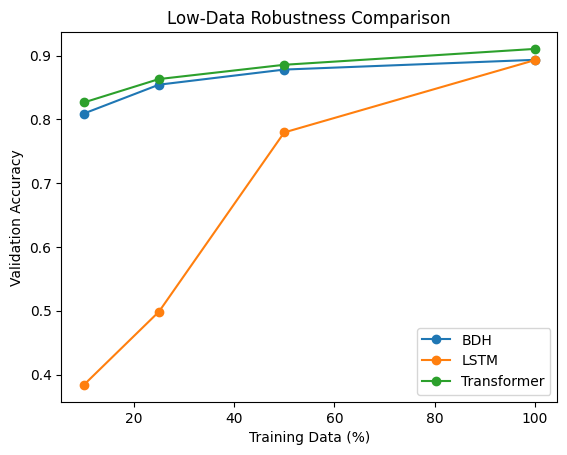

In [22]:
bdh_acc = []
lstm_acc = []
trans_acc = []

for frac in fractions:
    bdh_acc.append(results["BDH"][frac]["val_accuracy"][-1])
    lstm_acc.append(results["LSTM"][frac]["val_accuracy"][-1])
    trans_acc.append(results["Transformer"][frac]["val_accuracy"][-1])

plt.figure()
plt.plot([f*100 for f in fractions], bdh_acc, marker='o', label="BDH")
plt.plot([f*100 for f in fractions], lstm_acc, marker='o', label="LSTM")
plt.plot([f*100 for f in fractions], trans_acc, marker='o', label="Transformer")

plt.xlabel("Training Data (%)")
plt.ylabel("Validation Accuracy")
plt.title("Low-Data Robustness Comparison")
plt.legend()
plt.show()
